# Model training

In [ ]:
from pathlib import Path
from IPython.display import Audio
import torchaudio
import torchaudio.functional as taF
import torch.nn.functional as F
from sounds.hits import data as D
from sounds.hits.data import *
from torch.utils.data import DataLoader, RandomSampler
import numpy as np

In [ ]:
from typing import Mapping
import torchaudio.transforms as T
from torch import tensor
import torch, torch.nn as nn, torch.optim as optim
import torch.nn.functional as F
import math
import fastcore.all as fc
from fastprogress import master_bar, progress_bar
from functools import partial

In [ ]:
xs = np.load('../data/train/dataset_x.npy')
ys = np.load('../data/train/dataset_y.npy')
valid_xs = np.load('../data/valid/dataset_x.npy')
valid_ys = np.load('../data/valid/dataset_y.npy')

In [ ]:
def augment_data(audio):
    if np.random.rand() < 0.5: 
        audio = T.Vol(gain=1.5)(audio)
    if np.random.rand() < 0.5: 
        audio = taF.add_noise(audio, torch.randn_like(audio)*0.5, snr = torch.randint(12, 30, ()))
    return audio

In [ ]:
sr = 16_000
x_tfms = fc.Pipeline([tensor, T.Resample(new_freq=sr), T.MFCC(n_mfcc=64, melkwargs=dict(n_mels=64, norm='slaney'))])
y_tfms = [partial(tensor, dtype=torch.float32)]

In [ ]:
train = D.TfmDataset(merge_items(xs, ys), x_tfms, y_tfms)
valid = D.TfmDataset(merge_items(valid_xs, valid_ys), x_tfms, y_tfms)

In [ ]:
dls = dataloaders(train, valid, batch_size=32, shuffle=True)

In [ ]:
xb,yb = next(iter(dls.train))

<matplotlib.colorbar.Colorbar>

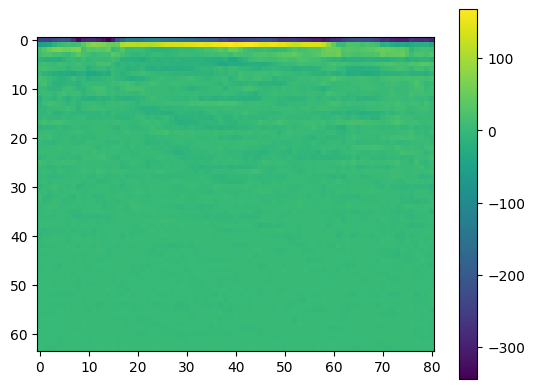

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(xb[0])
plt.colorbar()

# Model

In [ ]:
from torcheval.metrics import BinaryAccuracy
from sounds.learner import *
from sounds.hits.models import *

In [ ]:
dls = dataloaders(train, valid, batch_size=128, shuffle=True, num_workers=6)
model = MatchBoxNetwork(64, 64)
cbs = [DeviceCB(), MetricsCB(acc=BinaryAccuracy(threshold=torch.logit(tensor(0.5)))), ProgressCB()]
learn = Learner(dls,model, F.binary_cross_entropy_with_logits, opt_func=optim.Adam, cbs=cbs)

In [ ]:
learn.fit(5, lr=0.005)

In [ ]:
torch.save(model, '../models/model.pth')

# Test

In [ ]:
import librosa

In [ ]:
model = torch.load('../models/model.pth')

In [ ]:
path = Path('../data/thanos_message.wav')
sr = 16_000
detection_size = int(3.0*sr)
window_size_s = 1.0 # seconds
window_size = int(window_size_s*sr)
stride = int(0.7*sr)

In [ ]:
s, sr = librosa.load(path, sr=sr)

In [ ]:
def predict(audio, model, pipe=x_tfms, ths=0.7):
    logit = math.log(ths/(1-ths))
    x = to_device(pipe(audio)[None])
    return model(x) >= logit

In [ ]:
frames = split_audio(s, detection_size, detection_size//3)
res, last_det = [], False
for f in progress_bar(frames):
    if predict(f[window_size:2*window_size], model) and not last_det:
        res.append(f)
        last_det=True
    else: last_det=False

In [ ]:
Audio(np.concatenate(res), rate=sr)

In [ ]:
frames = split_audio(s, window_size, stride=stride)
dl = DataLoader(D.TfmDataset(merge_items(frames, frames), x_tfms), batch_size=256, num_workers=6)

In [ ]:
detected = []
for xb, yb in progress_bar(dl):
    with torch.no_grad():
        probs = F.sigmoid(model(to_device(xb))).cpu()
    detected += [(v,p.item()) for v,p in zip(yb,probs) if p>=0.75]

In [ ]:
fc.L(detected).map(lambda x: x[1])

(#14) [0.8661156296730042,0.9047421216964722,0.8060027360916138,0.7938315868377686,0.7816810607910156,0.9241520166397095,0.8180721402168274,0.9068080186843872,0.9042299389839172,0.9381250143051147...]

In [ ]:
Audio(torch.cat(list(fc.L(detected).map(lambda x: x[0]))), rate=sr)

# Export model

In [ ]:
model = torch.load('../models/model.pth', map_location='cpu')
x = torch.randn(1, 64, 81)
torch.onnx.export(model, x, 'model.onnx', input_names=['input'], output_names=['output'])